# TMC data - preprocessing

Read in raw xslx spreadsheets, format to a proper table, and save to csv.  

issue: https://github.com/CityofToronto/bdit_data-sources/issues/377  

In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np 
import importlib
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib.dates as mdates
from matplotlib.lines import Line2D # for legend

In [2]:
# Datetime
# import datetime
from datetime import date
from datetime import time
from datetime import datetime
from datetime import timedelta

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### TOC

**I   Read in xlsx files and output to one dataframe  
II  QC checks  
III Save to CSV  
IV  Plot counts for each mode**  

# I Read xlsx files and output to one dataframe
Output dataframe defined as `columns=['datetime_bin', 'location', 'class_type','count']`   
where:

- `datetime_bin` taken from `Time` column in each file  
- `location` taken from top of each file `Location:	Main Street Southbound North of Swanwick Avenue`  
- `class_type = [Cars,Trucks,Bicycles,Transit,Pedestrians,Other]` as read from the column headers in each file  
- `count` taken from the values in each `class_type` in the file  

In [5]:
data_dir='~/Documents/PROJECTS/BDITTO/WYS/VALIDATION/PREPROCESSED/'

# File list as output of `ls` in data dir.  
fname_list=[
    '2020-04-27_MAIN SOUTHBOUND NORTH OF SWANWICK.xlsx', 
    '2020-05-07_GATEWAY SOUTH EASTBOUND EAST OF DON MILLS.xlsx',
    '2020-04-28_NEWPORT EASTBOUND WEST OF AUGUST.xlsx', 
    '2020-05-11_UNDERHILL NORTHBOUND SOUTH OF MONARCHWOOD.xlsx',
    '2020-04-29_PHARMACY NORTHBOUND SOUTH OF DENTON.xlsx', 
    '2020-05-12_STRATFORD WESTBOUND WEST OF MILDENHALL.xlsx',
    '2020-04-30_DENTON WESTBOUND EAST OF BYNG.xlsx',
    '2020-05-13_BYNG NORTHBOUND SOUTH OF DENTON.xlsx',
    '2020-05-04_GRENOBLE WESTBOUND WEST OF LEEWARD GLENWAY EAST.xlsx', 
    '2020-05-14_PHARMACY SOUTHBOUND NORTH OF DENTON.xlsx',
    '2020-05-05_JONES SOUTHBOUND SOUTH OF HUNTER.xlsx',
    '2020-05-19_BELSIZE WESTBOUND EAST OF CHESTON.xlsx',
    '2020-05-06_JONES SOUTHBOUND SOUTH OF HARCOURT.xlsx', 
    '2020-05-20_CHESTON SOUTHBOUND NORTH OF BELSIZE.xlsx'
]

In [6]:
from datetime import timedelta

def read_xls():
    '''Read set of xlsx files, extract the relevant data, and format into a proper dataframe.'''
    
    # Set up output df
    df=pd.DataFrame(columns=['datetime_bin', 'location', 'class_type','count'])
    
    # Initialize arrays that will store values from each file
    timebin_array=[]
    location_array=[]
    classtype_array=[]
    count_array=[]
    
    # Loop through all files in fname_list, extract data from each column,
    # and append to one big long array that will then be stored in the 
    # final return df.
    idx=1
    for fname in fname_list:
        print('File ' + str(idx) + ': ' + fname)
        # 1. Read spreadsheet
        this_df=pd.read_excel(data_dir + fname, skiprows=9)  
        
        # 2. Convert all times to 24 hour notation in section after this_df['Time']=='Time'
        delta=timedelta(hours = 12)

        this_df.loc[this_df.index.values > this_df.loc[this_df['Time']=='Time'].index.values[0], 'Time']=(
            this_df.loc[this_df.index.values > 
                        this_df.loc[this_df['Time']=='Time'].index.values[0], 'Time'].apply(lambda x: (
            datetime.combine(date(1,1,1), x) + delta).time()))

        # 3. Exclude rows where Time col is not NaN and not of type datetime.time
        this_df['Time']=this_df['Time'].map(lambda x: x if isinstance(x, time) else np.nan)
        
        
        # Drop rows where Time is NaN -- these contain no data
        this_df=this_df.loc[~this_df['Time'].isnull()].reset_index(drop=True)
        
        # 4. Store location and observation date to variables
        this_loc=list(pd.read_excel(data_dir + fname, skiprows=3))[1]
        obs_date=list(pd.read_excel(data_dir + fname, skiprows=5))[1]
        
        print(this_loc)
        print('')
        idx=idx+1
        
        # 5. Add obs_date to times in Time col 
        this_df['Time']=this_df['Time'].apply(lambda x: datetime.combine(obs_date, x))
        
        # 6. Extract column values of this_df for each class_type
        #    and append to one long array for each 
        # NB: column names may have trailing or leading spaces, so loop through
        # the column names in each file separately
        for class_type in list(this_df)[1:]:
            location_array = location_array + [this_loc for i in range(len(list(this_df['Time'].values)))]
            
            # trim any trailing spaces from class_type
            classtype_array = classtype_array + [class_type.strip() for i in range(len(list(this_df['Time'].values)))]
            timebin_array=timebin_array + list(this_df['Time'].values)
            count_array=count_array + list(this_df[class_type].values)
            
        print('')
            
    # 7. Add all the arrays to the return df
    df['datetime_bin']=timebin_array
    df['location']=location_array
    df['class_type']=classtype_array
    df['count']=count_array
  
        
    return df

In [7]:
df_all=read_xls()

File 1: 2020-04-27_MAIN SOUTHBOUND NORTH OF SWANWICK.xlsx
Main Street Southbound North of Swanwick Avenue


File 2: 2020-05-07_GATEWAY SOUTH EASTBOUND EAST OF DON MILLS.xlsx
Gateway Boulevard South Eastbound East of Don Mills Road


File 3: 2020-04-28_NEWPORT EASTBOUND WEST OF AUGUST.xlsx
Newport Avenue Eastbound West of August Avenue


File 4: 2020-05-11_UNDERHILL NORTHBOUND SOUTH OF MONARCHWOOD.xlsx
Underhill Drive Northbound South of Monarchwood Crescent


File 5: 2020-04-29_PHARMACY NORTHBOUND SOUTH OF DENTON.xlsx
Pharmacy Avenue Northbound South of Denton Avenue


File 6: 2020-05-12_STRATFORD WESTBOUND WEST OF MILDENHALL.xlsx
Stratford Crescent Westbound West of Mildenhall Drive


File 7: 2020-04-30_DENTON WESTBOUND EAST OF BYNG.xlsx
Denton Avenue Westbound East of Byng Avenue


File 8: 2020-05-13_BYNG NORTHBOUND SOUTH OF DENTON.xlsx
Byng Avenue Northbound South of Denton Avenue


File 9: 2020-05-04_GRENOBLE WESTBOUND WEST OF LEEWARD GLENWAY EAST.xlsx
Grenoble Drive Westbound West

In [8]:
print(df_all.shape)
df_all.head()

(5544, 4)


,datetime_bin,location,class_type,count
0,2020-04-27 10:00:00,Main Street Southbound North of Swanwick Avenue,Cars,6.0
1,2020-04-27 10:05:00,Main Street Southbound North of Swanwick Avenue,Cars,8.0
2,2020-04-27 10:10:00,Main Street Southbound North of Swanwick Avenue,Cars,14.0
3,2020-04-27 10:15:00,Main Street Southbound North of Swanwick Avenue,Cars,8.0
4,2020-04-27 10:20:00,Main Street Southbound North of Swanwick Avenue,Cars,15.0


# II QC 

## II.1 Check there are 6 class_types

In [9]:
print(len(df_all['class_type'].unique()))
df_all['class_type'].unique()

6


array(['Cars', 'Trucks', 'Bicycles', 'Transit', 'Pedestrians', 'Other'],
      dtype=object)

In [10]:
# => check ok

## II.2 Check size
Final number of rows for each file should equal:  

`num_rows x num_cols`, where `num_cols` = 6



In [11]:
# Loop through each file and print out number of rows.
# Check that the number of rows matches manual check.

for loc in df_all['location'].unique():
    print(loc + ':')
    print(df_all.loc[df_all['location']==loc].shape)
    
# Manual check: open each file and count number of rows, multiply by number of columns
# Compare with output of print:

# Main Street Southbound North of Swanwick Avenue: 48 rows x 6 cols = 288. Check OK
# Gateway Boulevard South Eastbound East of Don Mills Road: 84 rows x 6 cols = 504. Check OK
# Newport Avenue Eastbound West of August Avenue: 48 rows x 6 cols = 288. Check OK
# Underhill Drive Northbound South of Monarchwood Crescent: 84 rows x 6 cols = 504. Check OK
# Pharmacy Avenue Northbound South of Denton Avenue: 48 rows x 6 cols = 288. Check OK
# Stratford Crescent Westbound West of Mildenhall Drive 84 rows x 6 cols = 504. Check OK
# Denton Avenue Westbound East of Byng Avenue: 48 rows x 6 cols = 288. Check OK
# Byng Avenue Northbound South of Denton Avenue: 84 rows x 6 cols = 504. Check OK
# Grenoble Drive Westbound West of Leeward Glenway East: 48 rows x 6 cols = 288. Check OK
# Pharmacy Avenue Southbound North of Denton Avenue: 84 rows x 6 cols = 504. Check OK
# Jones Avenue Southbound South of Hunter Street: 48 rows x 6 cols = 288. Check OK
# Belsize Drive Westbound East of Cheston Road: 84 rows x 6 cols = 504. Check OK
# Jones Avenue Southbound South of Harcourt Avenue: 48 rows x 6 cols = 288. Check OK
# Cheston Road Southbound North of Belsize Drive: 84 rows x 6 cols = 504. Check OK

Main Street Southbound North of Swanwick Avenue:
(288, 4)
Gateway Boulevard South Eastbound East of Don Mills Road:
(504, 4)
Newport Avenue Eastbound West of August Avenue:
(288, 4)
Underhill Drive Northbound South of Monarchwood Crescent:
(504, 4)
Pharmacy Avenue Northbound South of Denton Avenue:
(288, 4)
Stratford Crescent Westbound West of Mildenhall Drive:
(504, 4)
Denton Avenue Westbound East of Byng Avenue:
(288, 4)
Byng Avenue Northbound South of Denton Avenue:
(504, 4)
Grenoble Drive Westbound West of Leeward Glenway East:
(288, 4)
Pharmacy Avenue Southbound North of Denton Avenue:
(504, 4)
Jones Avenue Southbound South of Hunter Street:
(288, 4)
Belsize Drive Westbound East of Cheston Road:
(504, 4)
Jones Avenue Southbound South of Harcourt Avenue:
(288, 4)
Cheston Road Southbound North of Belsize Drive:
(504, 4)


# III Save to csv

In [12]:
print(df_all.shape)

saveflag=False
if saveflag:
    savename='validation_all.csv'
    df_all.sort_values('datetime_bin').reset_index(drop=True).to_csv(data_dir + savename, sep=';',index=False)

(5544, 4)


# IV Plot counts
Line plots for each mode.  

## IV.1 Function to reshape dataframe into columns for each street

In [13]:
def make_linedf(df):
    '''Reshape df into format for line plot.'''
    
    # 1. Make dict for location strings (they are very long)
    locations=df_all['location'].unique()
    loc_dict=dict(list(enumerate(locations)))
    
    col_array=['line' + str(x) for x in list(loc_dict.keys())]
    col_array=['datetime_bin'] + col_array
    
    # 2. Strip date from datetime_bin
    df['datetime_bin']=df['datetime_bin'].apply(lambda x: x.time())
    
    # 3. Pivot to make a column for each location
    df=df.pivot(index='datetime_bin',columns='location',values='count').reset_index() #.rename_axis(None,1)
    
    # 4. Rename columns (location strings too long)
    df.columns=col_array
    
    # Convert NaNs to None to have gaps in plot where data is missing
    df=df.where(pd.notnull(df), None)
    
    return df

## IV.2 Multi-line chart 
From Plotting Gallery.  

In [14]:
def multi_linechart(df_line, sett):
    '''From Plotting Gallery.
    
    Creates a line chart of one or more lines.

    Number of lines to plot determined from columns in input dataframe.

    Parameters
    -----------
    df_orig : pandas dataframe
        First column contains x-axis data, subsequent column(s) contain y-axis data.
    sett : dict
        Styling and annotation specification for all visual elements 
        (e.g. axes, grid, lines, legend, title, labels). If empty, defaults are used.
    sett['body'] : dict key, optional
        Global style parameters for 'font-size', 'font-family', and 'fontfamily-list'. 
        If empty, defaults are used.
    sett['body']['font-size'] : int, optional dict key
        Global font size for plot. Default 12.
    sett['body']['font-family'] : str, optional dict key
        Global font family for plot. Default 'sans-serif'.
    sett['body']['fontfamily-list'] : array, optional dict key
        Array of fonts in font-family. The first font in the array that is 
        installed in the system will be used. Default 'Libre Franklin'.
    
    Returns 
    --------
    fig
        Matplotlib fig object
    ax 
        Matplotlib ax object
 
    ''' 
    df=df_line.copy()
    
    # ----------------------------------------------
    # Setup the figure
    fig, ax =plt.subplots(1)
    fig.set_size_inches(18, 12)
    ax = plt.gca()
    
    
    # ----------------------------------------------
    # Default styling params if not defined in sett
    if 'body' in sett:
        dflt={
            'font-size':(12 if 'font-size' not in sett['body']
                         else sett['body']['font-size']),
            'font-family':('sans-serif' if 'font-family' not in sett['body']
                         else sett['body']['font-family']),
            'fontfamily-list':(['Libre Franklin', 'DejaVu Sans'] if 'fontfamily-list' 
                          not in sett['body']
                          else sett['body']['fontfamily-list']),
            'stroke':('#000000' if 'stroke' not in sett['body']
                         else sett['body']['stroke']),
            'stroke-width':(2 if 'stroke-width' not in sett['body']
                         else sett['body']['stroke-width']),
            'border':('solid' if 'border' not in sett['body']
                         else sett['body']['border'])
        }
    else:
        dflt={
            'font-size':12, 'font-family':'sans-serif',
            'fontfamily-list':['Libre Franklin', 'DejaVu Sans'],
            'stroke':'#000000', 'stroke-width':2, 'border':'solid'
        }
 
    print(dflt['font-family'])
    mpl.rcParams['font.family'] = dflt['font-family']
    if dflt['font-family']=='sans-serif':
        mpl.rcParams['font.sans-serif']=dflt['fontfamily-list']
    
#     mpl.rcParams.update({
#         'font.size': dflt['font-size'],
#         'font.family': dflt['font-family']
#     })
    # ----------------------------------------------------------------
    # WEIRD HACK !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # For some reason, mpl.rcParams needs to be run TWICE before it 
    # actually gets set. So just before calling the function, 
    # make sure you set it again...
    # ----------------------------------------------------------------
    
    
    # ----------------------------------------------
    # Define line-number-dependent params
    num_lines=df.shape[1] - 1
    
    col_names=['xcol']
    ymax_array=[]
    for n in range(num_lines):
        col_names.append('ycol_' + str(n))
        ymax_array.append(df.iloc[:,n+1].max())
        
    df.columns=col_names
    
    # ----------------------------------------------
    # title
    if 'title' in sett:
        if 'title_params' in sett:
            title_size=(
                dflt['font-size'] if 'font-size' not in 
                sett['title_params']
                else sett['title_params']['font-size'])
            loc=('center' if 'loc' not in sett['title_params']
                 else sett['title_params']['loc'])
        ax.set_title(sett['title'], fontsize=title_size,  loc=loc)
    
    # ----------------------------------------------
    # grid
    if 'major_grid_on' in sett and sett['major_grid_on']==True:      
        if 'major_grid' in sett:
            c=('gray' if 'stroke' not in sett['major_grid']
               else sett['major_grid']['stroke'])
            b=('-' if 'border' not in sett['major_grid']
               else sett['major_grid']['border'])
        else: 
            c='gray'
            b='-'
        plt.grid(b=True, which='major', color=c, linestyle=b)
    if 'minor_grid_on' in sett and sett['minor_grid_on']==True:      
        if 'minor_grid' in sett:
            c=('gray' if 'stroke' not in sett['minor_grid']
               else sett['minor_grid']['stroke'])
            b=('-' if 'border' not in sett['minor_grid']
               else sett['minor_grid']['border'])
        else: 
            c='gray'
            b='-'
        plt.grid(b=True, which='minor', color=c, linestyle=b)

    
    # ----------------------------------------------
    # axes (both)
    mpl.rcParams['axes.linewidth'] = 0.3
    ticklength=2 if 'ticklength' not in sett else sett['ticklength']
    tickwidth=1 if 'tickwidth' not in sett else sett['tickwidth']
    ax.tick_params(width=tickwidth, length=ticklength)
    
    # y-axis
    if 'yaxis' in sett:
        ymin=(0 if 'ymin' not in sett['yaxis']
              else sett['yaxis']['ymin'])
        ymax=(np.max(ymax_array)*(1 + 0.1) if 'ymax'
              not in sett['yaxis']
              else sett['yaxis']['ymax'])
        
        # y-axis label
        label=('' if 'label' not in sett['yaxis']
               else sett['yaxis']['label'])
        labelsize=(dflt['font-size'] if 'labelsize'
                   not in sett['yaxis']
                   else sett['yaxis']['labelsize'])
        plt.ylabel(label, fontsize=labelsize)
        
        # Format y-axis tick labels
        ticklabelsize=(dflt['font-size'] if 'ticklabelsize'
                  not in sett['yaxis']
                  else sett['yaxis']['ticklabelsize'])
        ax.tick_params(axis='y', labelsize=ticklabelsize)
        
        # comma format
        precision=('.0f' if 'precision'
                   not in sett['yaxis']
                   else sett['yaxis']['precision'])
        ax.yaxis.set_major_formatter(
            mpl.ticker.StrMethodFormatter('{x:,' + precision + '}')
        )
    else:
        ymin=0
        ymax=np.max(ymax_array)*(1 + 0.1)
        
        # Default y-axis formats
        ax.tick_params(axis='y', labelsize=dflt['font-size'])
        ax.yaxis.set_major_formatter(
            mpl.ticker.StrMethodFormatter('{x:,.0f}') # comma format
        ) 
          
    delta = (ymax - ymin)/4
    i = 0
    while True:
        delta /= 10
        i += 1
        if delta < 10:
            break
    if 'yinc' in sett:
        yinc=sett['yinc']
    else:
        yinc = int(round(delta+1)*pow(10,i))
                   
    plt.ylim(top=ymax, bottom=ymin)
    
    # ----------------------------------------------
    # x-axis
    if 'xaxis' in sett:
        # x-axis label
        label=('' if 'label' not in sett['xaxis']
               else sett['xaxis']['label'])
        labelsize=(dflt['font-size'] if 'labelsize'
                   not in sett['xaxis']
                   else sett['xaxis']['labelsize'])
        plt.xlabel(label, fontsize=labelsize)
        
        # x-axis tick labels
        if 'major_loc' in sett['xaxis']: # x-values are dates  
            date_form_mjr = sett['xaxis']['major_loc']['date_form']
            ax.xaxis.set_major_formatter(date_form_mjr)
        if 'minor_loc' in sett['xaxis']:
            date_form_mnr = sett['xaxis']['minor_loc']['date_form']
            ax.xaxis.set_minor_locator(date_form_mnr)
        
        # x-axis tick label size
        ticklabelsize=(dflt['font-size'] if 'ticklabelsize'
                  not in sett['xaxis']
                  else sett['xaxis']['ticklabelsize'])
        ax.tick_params(axis='x', labelsize=ticklabelsize, 
                       labelbottom=True)
    else:
        # Default x-axis tick lines
        ax.tick_params(axis='x', labelsize=dflt['font-size'],
                       labelbottom=True)
        

    # ----------------------------------------------
    # Plot data and legend
    if 'legend' in sett:
        legend_loc=('upper left' if 'loc' not in sett['legend']
                    else sett['legend']['loc'])
        leg_array=[]
        custom_lines=[]
        ncol=len(df.columns) if 'ncol' not in sett['legend'] else sett['legend']['ncol']
        
    for n in range(num_lines):
        if 'lines' in sett:
            line_colour=(dflt['stroke'] if 'stroke' not in 
                         sett['lines'][n] 
                         else sett['lines'][n]['stroke'])
            line_width=(dflt['stroke-width'] if 'stroke-width' 
                        not in sett['lines'][n] 
                        else sett['lines'][n]['stroke-width'])
            border_style=(dflt['border'] if 'border-style' not in 
                          sett['lines'][n] 
                          else sett['lines'][n]['border-style'])
        else:
            line_colour=dflt['stroke']
            line_width=dflt['stroke-width']
            border_style=dflt['border']
            
        ax.plot(df['xcol'], df['ycol_' + str(n)], linewidth=line_width, 
                color = line_colour, linestyle=border_style)
        
        # Legend
        if 'legend' in sett:
            leg_array.append(sett['lines'][n]['label'])
            custom_lines.append(Line2D([0], [0], 
                                       color=line_colour, 
                                       lw=line_width,
                                       linestyle=border_style)
                               )
    
    if 'legend' in sett:
        ax.legend(custom_lines, leg_array, loc=legend_loc, 
                  prop={"size": dflt['font-size']},
                  ncol=ncol)

    
    # ----------------------------------------------
    # Plot shaded areas
    if 'shaded' in sett:
        num_a=len(sett['shaded'].keys())
        
        for area in range(num_a):
            idx=sett['shaded'][area]['lims']
            facecolour=sett['shaded'][area]['fill']
            zorder=(0 if 'zorder' not in sett['shaded'][area] 
                    else sett['shaded'][area]['zorder'])
            alpha=(1 if 'alpha' not in sett['shaded'][area]
                   else sett['shaded'][area]['alpha'])
            
            # Shaded area left and right bds
            for i in range(len(idx)):
                bd1=idx[i][0]
                bd2=idx[i][1]
                
                ax.axvspan(bd1, bd2, facecolor=facecolour, 
                           edgecolor='none', alpha=alpha,
                           zorder=zorder)
            
            # Shaded area label
            if 'label' in sett['shaded'][area]:
                rot=(0 if 'rotation' not in 
                     sett['shaded'][area]['label'] 
                     else sett['shaded'][area]['label']['rotation'])
                label_colour=(dflt['stroke'] if 'colour' not in 
                              sett['shaded'][area]['label'] 
                              else sett['shaded'][area]['label']['colour'])
                label_size=(dflt['font-size'] if 'font-size' not in 
                            sett['shaded'][area]['label'] 
                            else sett['shaded'][area]['label']['font-size'])
                plt.text(                    
                    sett['shaded'][area]['label']['x'], # x posn of label
                    sett['shaded'][area]['label']['y'], # y posn of label
                    sett['shaded'][area]['label']['text'], 
                    rotation=rot, 
                    color=label_colour, 
                    fontsize=label_size
                )

    return fig, ax

## IV.3 Base settings for line chart
Settings for 14 lines.  

In [15]:
# Dictionaries for labels
locations=df_all['location'].unique()
short_locations=[' '.join(x.split()[:3]) for x in locations]
short_locations=[x.replace('Southbound', 'SB') for x in short_locations]
short_locations=[x.replace('Northbound', 'NB') for x in short_locations]
short_locations=[x.replace('Eastbound', 'EB') for x in short_locations]
short_locations=[x.replace('Westbound', 'WB') for x in short_locations]
short_locations=[x.replace('Avenue', 'Ave') for x in short_locations]
short_locations=[x.replace('Street', 'St') for x in short_locations]
short_locations=[x.replace('Drive', 'Dr') for x in short_locations]
short_locations=[x.replace('Crescent', 'Cres') for x in short_locations]
short_locations=[x.replace('Boulevard', 'Blvd') for x in short_locations]
short_locations=[x.replace('Road', 'Rd') for x in short_locations]
short_locations=[x.replace('South', 'S') for x in short_locations]


colour_array=['#4477AA','#66CCEE','#228833','#CCBB44','#EE6677',
             '#AA3377','#BBBBBB','#EE7733','#CC3311','#EE3377',
             '#882255','#CC6677','#222255','#555555']

loc_dict=dict(list(enumerate(locations)))
short_loc_dict=dict(list(enumerate(short_locations)))
colour_dict=dict(list(enumerate(colour_array)))  #dict(zip(locations, colour_array))

In [16]:
sett = {
    'body': {
        'font-size': 16,
        'font-family': 'sans-serif',
        'stroke-width': 2
    },
    
    # Axes labels and limits
    'yaxis': {
        'label': 'Counts',
        'labelsize': 18
    },
    'xaxis':{
        'label': 'Time',
        'labelsize': 18
    },    
    # grid
    'major_grid_on': True,
    'minor_grid_on': False,
    
    # legend
    'legend': {
        'loc': 'upper left',
        'ncol': 3
    },

    'lines': {
        0: {'stroke':colour_dict[0], 'label': short_loc_dict[0]},
        1: {'stroke':colour_dict[1], 'label': short_loc_dict[1]},
        2: {'stroke':colour_dict[2], 'label': short_loc_dict[2]},
        3: {'stroke':colour_dict[3], 'label': short_loc_dict[3]},
        4: {'stroke':colour_dict[4], 'label': short_loc_dict[4]},
        5: {'stroke':colour_dict[5], 'label': short_loc_dict[5]},
        6: {'stroke':colour_dict[6], 'label': short_loc_dict[6]},
        7: {'stroke':colour_dict[7], 'label': short_loc_dict[7]},
        8: {'stroke':colour_dict[8], 'label': short_loc_dict[8]},
        9: {'stroke':colour_dict[9], 'label': short_loc_dict[9]},
        10: {'stroke':colour_dict[10], 'label': short_loc_dict[10]},
        11: {'stroke':colour_dict[11], 'label': short_loc_dict[11]},
        12: {'stroke':colour_dict[12], 'label': short_loc_dict[12]},
        13: {'stroke':colour_dict[13], 'label': short_loc_dict[13]}
    }
}

# ----------------------------------------------------------------
# WEIRD HACK !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# For some reason, you need to run mpl.rcParams TWICE before it 
# actually gets set. The mpl.rcParams is already specified in 
# multi_linechart() but here we run it for the second time otherwise
# the font.family will not be updated
if 'body' in sett:
    if 'font-family' in sett['body']:
        mpl.rcParams['font.family'] = sett['body']['font-family']
        print(mpl.rcParams['font.family'])

['sans-serif']


## IV.4 Line plots for each mode 
There are 6 modes:  

In [17]:
print(df_all['class_type'].unique())

['Cars' 'Trucks' 'Bicycles' 'Transit' 'Pedestrians' 'Other']


sans-serif


(<Figure size 1296x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0d61d582e8>)

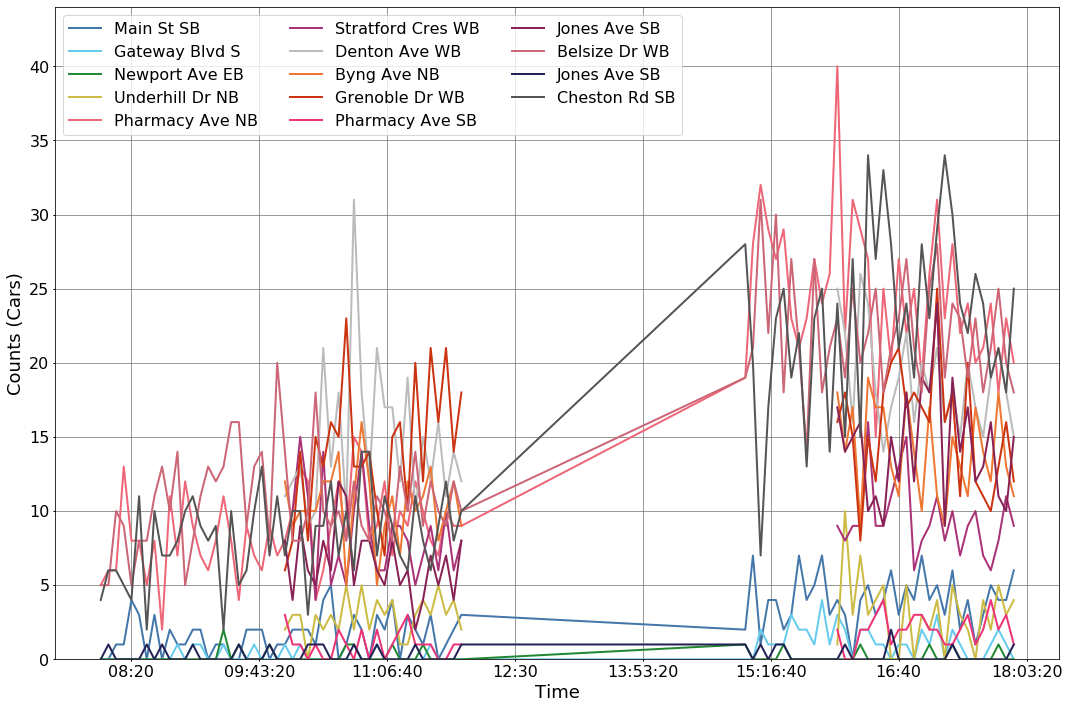

In [18]:
mode='Cars'
sett['yaxis']['label']='Counts (' + mode + ')' 
df_cars=make_linedf(df_all.loc[df_all['class_type']==mode, ['datetime_bin','location','count']])

multi_linechart(df_cars, sett)

sans-serif


(<Figure size 1296x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0d5cf6d9b0>)

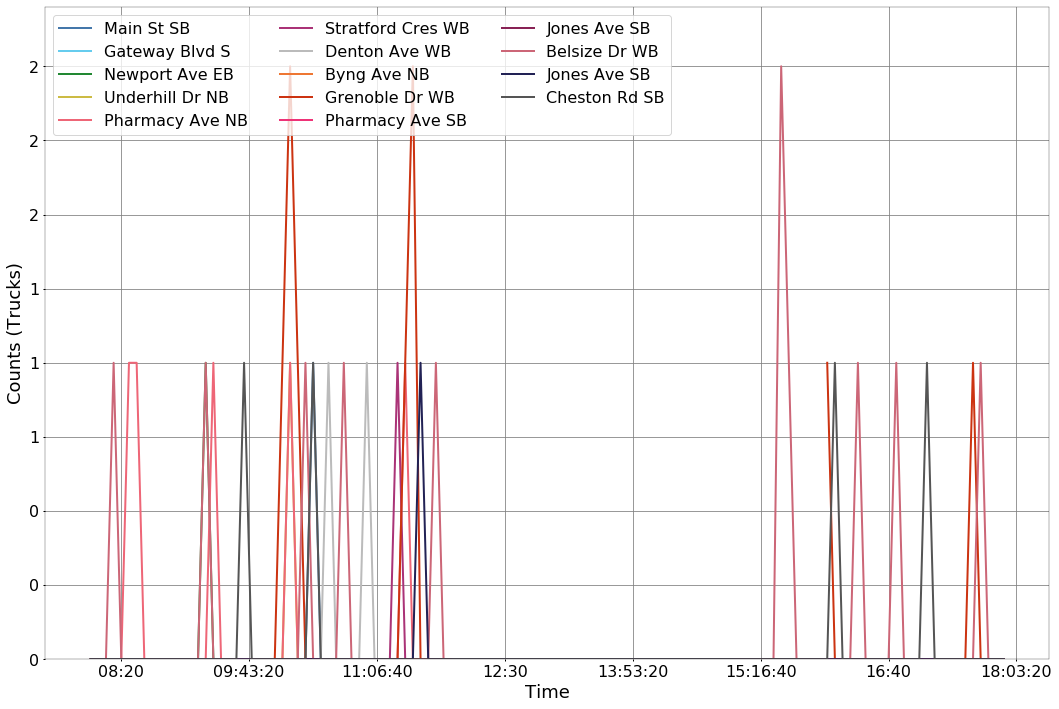

In [19]:
mode='Trucks'

sett['yaxis']['label']='Counts (' + mode + ')' 
df_trucks=make_linedf(df_all.loc[df_all['class_type']==mode, ['datetime_bin','location','count']])

multi_linechart(df_trucks, sett)

sans-serif


(<Figure size 1296x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0d5cf87400>)

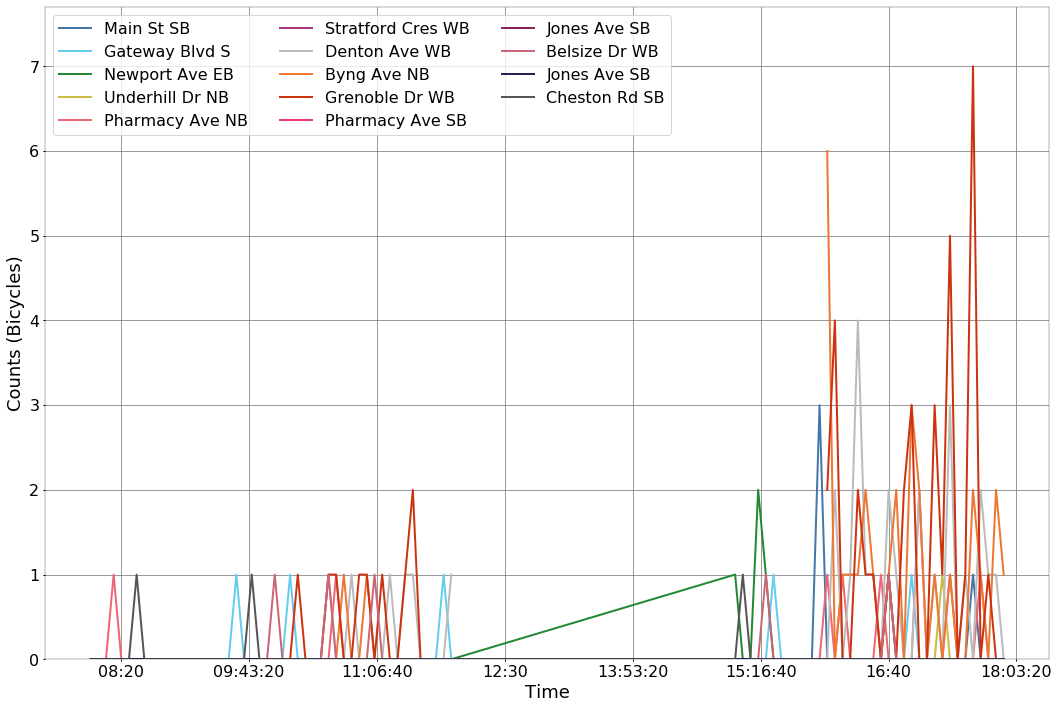

In [20]:
mode='Bicycles'

sett['yaxis']['label']='Counts (' + mode + ')' 
df_bikes=make_linedf(df_all.loc[df_all['class_type']==mode, ['datetime_bin','location','count']])

multi_linechart(df_bikes, sett)

sans-serif


(<Figure size 1296x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0d61d14c88>)

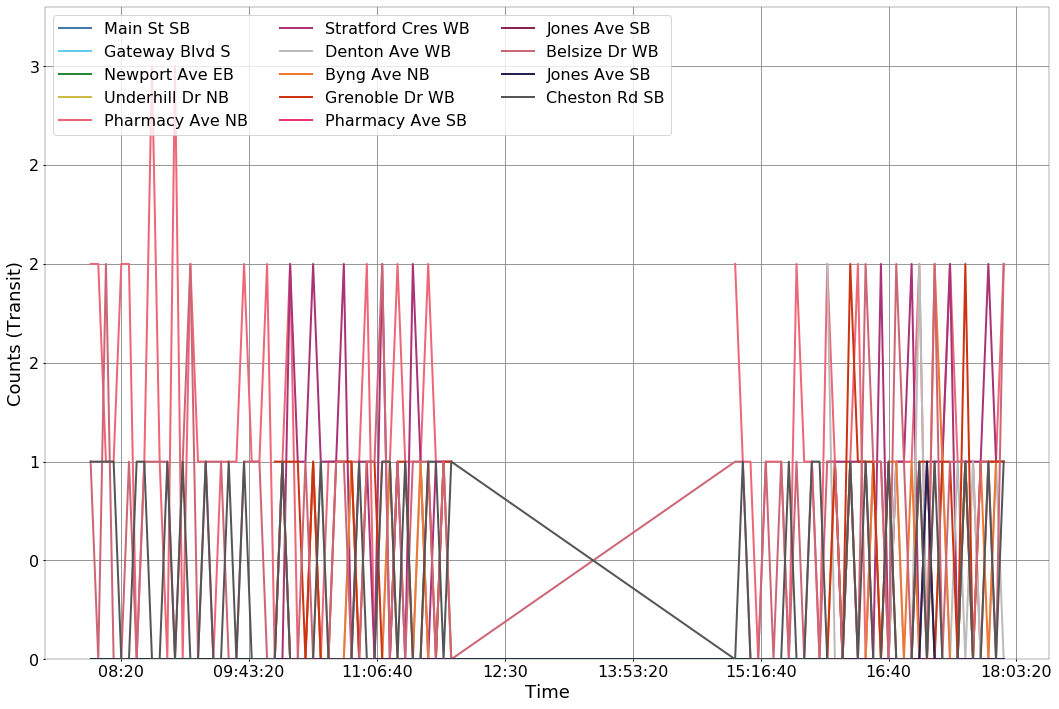

In [21]:
mode='Transit'

sett['yaxis']['label']='Counts (' + mode + ')' 
df_transit=make_linedf(df_all.loc[df_all['class_type']==mode, ['datetime_bin','location','count']])

multi_linechart(df_transit, sett)

sans-serif


(<Figure size 1296x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0d5d229cc0>)

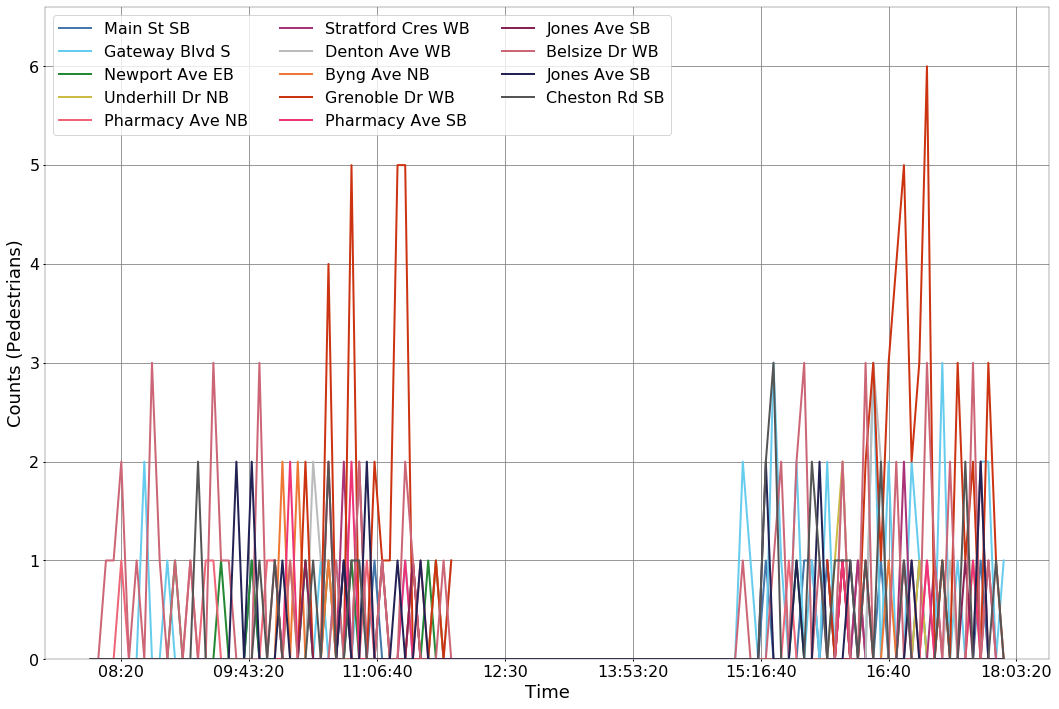

In [22]:
mode='Pedestrians'

sett['yaxis']['label']='Counts (' + mode + ')' 
df_peds=make_linedf(df_all.loc[df_all['class_type']==mode, ['datetime_bin','location','count']])

multi_linechart(df_peds, sett)

sans-serif


/home/nangini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:191: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


(<Figure size 1296x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0d5d174940>)

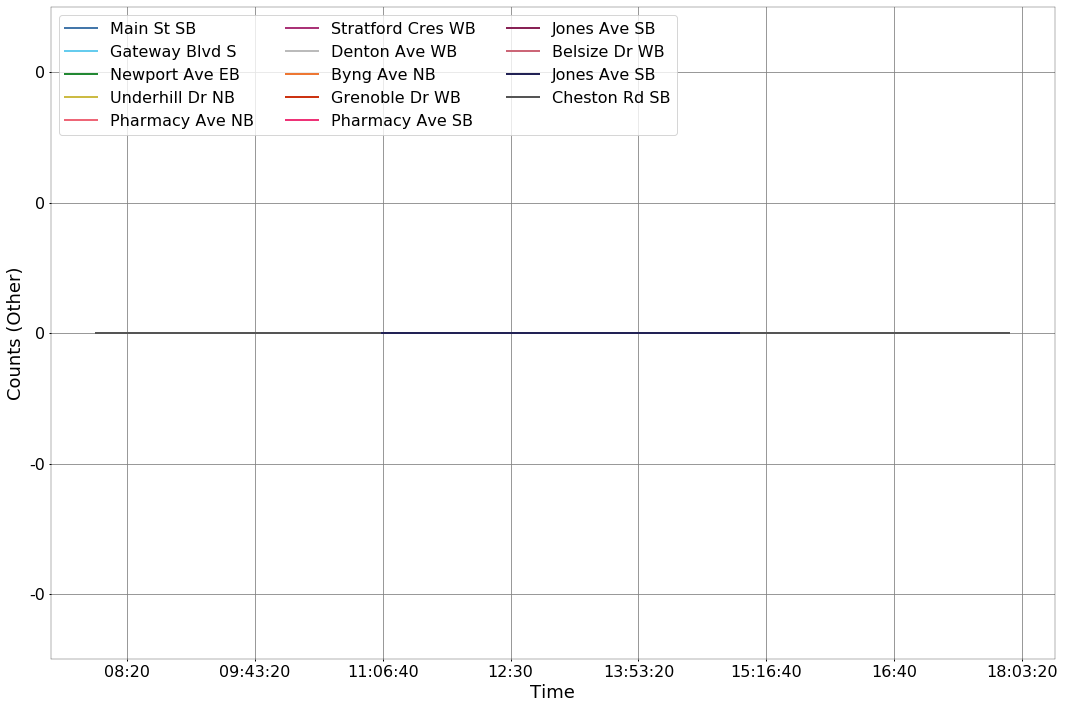

In [23]:
mode='Other'

sett['yaxis']['label']='Counts (' + mode + ')' 
df_other=make_linedf(df_all.loc[df_all['class_type']==mode, ['datetime_bin','location','count']])

multi_linechart(df_other, sett)